## 1. Import

In [43]:
import pandas as pd
import numpy as np

import re
import string
from urllib.parse import urlparse
from tldextract import extract as tld_extract
from tld import get_tld, is_tld
from tld.utils import update_tld_names
from tld.exceptions import TldDomainNotFound, TldBadUrl, TldIOError

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

## 2. Data Load

In [44]:
# 학습/평가 데이터 로드
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# '[.]'을 '.'으로 복구
train_df['URL'] = train_df['URL'].str.replace(r'\[\.\]', '.', regex=True)
test_df['URL'] = test_df['URL'].str.replace(r'\[\.\]', '.', regex=True)

In [45]:
train_df.isnull().sum()

ID       0
URL      0
label    0
dtype: int64

In [46]:
train_df['label'].value_counts()

label
0    5430159
1    1564897
Name: count, dtype: int64

## 3. Feature-Engineering (FE)

In [47]:
## 새로운 변수 생성
# URL 길이
train_df['length'] = train_df['URL'].str.len()
test_df['length'] = test_df['URL'].str.len()

# 서브도메인 개수
train_df['subdomain_count'] = train_df['URL'].str.split('.').apply(lambda x: len(x) - 2)
test_df['subdomain_count'] = test_df['URL'].str.split('.').apply(lambda x: len(x) - 2)

# 특수 문자 개수
train_df['special_char_count'] = train_df['URL'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
test_df['special_char_count'] = test_df['URL'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5


In [48]:
# 문자 개수
def count_letters(url):
    num_letters = sum(char.isalpha() for char in url)
    return num_letters


# 숫자 개수
def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits


train_df["num_letters"] = train_df["URL"].apply(count_letters)
train_df["num_digits"] = train_df["URL"].apply(count_digits)
test_df["num_letters"] = test_df["URL"].apply(count_letters)
test_df["num_digits"] = test_df["URL"].apply(count_digits)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2


In [49]:
# # URL에서 최상위 도메인 추출
# def extract_pri_domain(url):
#     try:
#         res = get_tld(url, as_object=True, fail_silently=False, fix_protocol=True)
#         pri_domain = res.parsed_url.netloc
#     except :
#         pri_domain = None
#     return pri_domain

# train_df["pri_domain"] = train_df['URL'].apply(lambda x: extract_pri_domain(x))
# test_df["pri_domain"] = test_df['URL'].apply(lambda x: extract_pri_domain(x))

# train_df.head()

In [50]:
# 짧은 링크인지 여부
def has_shortening_service(url):
    pattern = re.compile(r'(?:\w+\.)*(\w+)\.\w+')
    match = pattern.search(url)
    
    if match:
        domain = match.group(1)
        common_shortening_services = ['bit', 'goo', 'tinyurl', 'ow', 't', 'is',
                                      'cli', 'yfrog', 'migre', 'ff', 'url4', 'twit',
                                      'su', 'snipurl', 'short', 'BudURL', 'ping', 
                                      'post', 'Just', 'bkite', 'snipr', 'fic', 
                                      'loopt', 'doiop', 'kl', 'wp', 
                                      'rubyurl', 'om', 'to', 'lnkd', 
                                      'db', 'adf', 'bitly', 'cur', 'ity', 'q', 
                                      'po', 'bc', 'twitthis', 'j', 'buzurl', 
                                      'cutt', 'u', 'yourls', 'x', 'prettylinkpro', 
                                      'scrnch', 'filoops', 'vzturl', 'qr', '1url', 
                                      'tweez', 'v', 'tr', 'link', 'zip']
        
        if domain.lower() in common_shortening_services:
            return 1
    return 0

train_df["shortened"] = train_df["URL"].apply(has_shortening_service)
test_df["shortened"] = test_df["URL"].apply(has_shortening_service)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0


In [51]:
# URL에 https 포함 여부
def include_https(url):
    if "https" in url:
        return 1
    return 0

train_df["https"] = train_df["URL"].apply(include_https)
test_df["https"] = test_df["URL"].apply(include_https)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened,https
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0,0


In [ ]:
# 대문자 포함 여부
def include_uppercase(url):
    if any(x.isupper() for x in url):
        return 1
    return 0

train_df["uppercase"] = train_df["URL"].apply(include_uppercase)
test_df["uppercase"] = test_df["URL"].apply(include_uppercase)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened,https,uppercase,ip_address,at_symbol,double_slash,extension_check,randomness,typosquatting,uppercase_length
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0,0,0,0,0,0,0,0.600827,0.2,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0,0,0,0,0,0,0,0.587135,0.2,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0,0,0,0,0,0,0,0.597280,0.0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0,0,0,0,0,0,0,0.593377,0.2,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0,0,1,0,0,0,0,0.667245,0.4,1


In [53]:
# URL에 IP 주소 포함 여부
def include_ip_address(url):
    pattern = re.compile(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}')
    match = pattern.search(url)
    
    if match:
        return 1
    return 0

train_df["ip_address"] = train_df["URL"].apply(include_ip_address)
test_df["ip_address"] = test_df["URL"].apply(include_ip_address)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened,https,uppercase,ip_address
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0,0,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0,0,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0,0,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0,0,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0,0,1,0


In [54]:
# URL에 @ 포함 여부
def include_at_symbol(url):
    if "@" in url:
        return 1
    return 0

train_df["at_symbol"] = train_df["URL"].apply(include_at_symbol)
test_df["at_symbol"] = test_df["URL"].apply(include_at_symbol)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened,https,uppercase,ip_address,at_symbol
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0,0,0,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0,0,0,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0,0,0,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0,0,0,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0,0,1,0,0


In [55]:
# URL에 // 포함 여부
def include_double_slash(url):
    if "//" in url:
        return 1
    return 0

train_df["double_slash"] = train_df["URL"].apply(include_double_slash)
test_df["double_slash"] = test_df["URL"].apply(include_double_slash)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened,https,uppercase,ip_address,at_symbol,double_slash
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0,0,0,0,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0,0,0,0,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0,0,0,0,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0,0,0,0,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0,0,1,0,0,0


In [56]:
# # URL에 포함된 - 개수
# def count_hyphen(url):
#     return url.count("-")

# train_df["hyphen"] = train_df["URL"].apply(count_hyphen)
# test_df["hyphen"] = test_df["URL"].apply(count_hyphen)

# train_df.head()

In [57]:
# 파일확장자 포함 여부
def check_extension(url):
    extensions = [
        ".php",
        ".html",
        ".htm",
        ".hwp",
        ".hwpx",
        ".pptx",
        ".docx",
        ".iso",
        ".js",
        ".lnk",
        ".vbs",
        ".xls",
        ".xml",
        ".zip",
        ".xlsx",
    ]
    for ext in extensions:
        if ext in url:
            return 1
    return 0


train_df["extension_check"] = train_df["URL"].apply(lambda url: check_extension(url))
test_df["extension_check"] = test_df["URL"].apply(lambda url: check_extension(url))

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened,https,uppercase,ip_address,at_symbol,double_slash,extension_check
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0,0,0,0,0,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0,0,0,0,0,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0,0,0,0,0,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0,0,0,0,0,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0,0,1,0,0,0,0


In [58]:
# # 국가 코드 포함 여부
# COUNTRY_CODE_TLDS = {
#     'ac', 'ad', 'ae', 'af', 'ag', 'ai', 'al', 'am', 'ao', 'aq', 'ar', 'as', 'at', 'au', 'aw', 'ax', 'az',
#     'ba', 'bb', 'bd', 'be', 'bf', 'bg', 'bh', 'bi', 'bj', 'bl', 'bm', 'bn', 'bo', 'bq', 'br', 'bs', 'bt',
#     'bv', 'bw', 'by', 'bz', 'ca', 'cc', 'cd', 'cf', 'cg', 'ch', 'ci', 'ck', 'cl', 'cm', 'cn', 'co', 'cr',
#     'cu', 'cv', 'cw', 'cx', 'cy', 'cz', 'de', 'dj', 'dk', 'dm', 'do', 'dz', 'ec', 'ee', 'eg', 'eh', 'er',
#     'es', 'et', 'eu', 'fi', 'fj', 'fk', 'fm', 'fo', 'fr', 'ga', 'gb', 'gd', 'ge', 'gf', 'gg', 'gh', 'gi',
#     'gl', 'gm', 'gn', 'gp', 'gq', 'gr', 'gs', 'gt', 'gu', 'gw', 'gy', 'hk', 'hm', 'hn', 'hr', 'ht', 'hu',
#     'id', 'ie', 'il', 'im', 'in', 'io', 'iq', 'ir', 'is', 'it', 'je', 'jm', 'jo', 'jp', 'ke', 'kg', 'kh',
#     'ki', 'km', 'kn', 'kp', 'kr', 'kw', 'ky', 'kz', 'la', 'lb', 'lc', 'li', 'lk', 'lr', 'ls', 'lt', 'lu',
#     'lv', 'ly', 'ma', 'mc', 'md', 'me', 'mf', 'mg', 'mh', 'mk', 'ml', 'mm', 'mn', 'mo', 'mp', 'mq', 'mr',
#     'ms', 'mt', 'mu', 'mv', 'mw', 'mx', 'my', 'mz', 'na', 'nc', 'ne', 'nf', 'ng', 'ni', 'nl', 'no', 'np',
#     'nr', 'nu', 'nz', 'om', 'pa', 'pe', 'pf', 'pg', 'ph', 'pk', 'pl', 'pm', 'pn', 'pr', 'ps', 'pt', 'pw',
#     'py', 'qa', 're', 'ro', 'rs', 'ru', 'rw', 'sa', 'sb', 'sc', 'sd', 'se', 'sg', 'sh', 'si', 'sj', 'sk',
#     'sl', 'sm', 'sn', 'so', 'sr', 'ss', 'st', 'sv', 'sx', 'sy', 'sz', 'tc', 'td', 'tf', 'tg', 'th', 'tj',
#     'tk', 'tl', 'tm', 'tn', 'to', 'tr', 'tt', 'tv', 'tw', 'tz', 'ua', 'ug', 'uk', 'um', 'us', 'uy', 'uz',
#     'va', 'vc', 've', 'vg', 'vi', 'vn', 'vu', 'wf', 'ws', 'ye', 'yt', 'za', 'zm', 'zw'
# }

# def is_country_code(url):
#     try:
#         # URL에서 TLD 추출
#         res = get_tld(url, as_object=True, fix_protocol=True)
        
#         # TLD가 국가 코드인지 확인
#         if res.tld in COUNTRY_CODE_TLDS:
#             return 1
#         return 0
#     except:
#         return 0
    
# train_df["country_code"] = train_df["URL"].apply(is_country_code)
# test_df["country_code"] = test_df["URL"].apply(is_country_code)

# train_df.head()

In [59]:
# URL 무작위성
import math
from collections import Counter

def calculate_entropy(url):
    # 문자 빈도수 계산
    counter = Counter(url)
    length = len(url)
    
    # 섀넌 엔트로피 계산
    entropy = 0
    for count in counter.values():
        probability = count / length
        entropy -= probability * math.log2(probability)
    return entropy

def check_randomness(url):
    # 1. 엔트로피 계산
    entropy = calculate_entropy(url)
    
    # 2. 연속된 숫자나 문자의 최대 길이
    max_consecutive = 1
    current_consecutive = 1
    for i in range(1, len(url)):
        if url[i].isalnum() and url[i-1].isalnum() and url[i].lower() == url[i-1].lower():
            current_consecutive += 1
            max_consecutive = max(max_consecutive, current_consecutive)
        else:
            current_consecutive = 1
    
    # 3. 숫자와 문자의 교차 패턴 수
    transitions = 0
    for i in range(1, len(url)):
        if (url[i-1].isdigit() and url[i].isalpha()) or \
           (url[i-1].isalpha() and url[i].isdigit()):
            transitions += 1
    
    # 무작위성 점수 계산 (0~1 사이로 정규화)
    entropy_score = min(entropy / 5.0, 1.0)  # 일반적인 URL의 최대 엔트로피를 5로 가정
    consecutive_score = min(max_consecutive / 10.0, 1.0)  # 연속된 문자가 많을수록 낮은 점수
    transition_score = min(transitions / 10.0, 1.0)  # 전환이 많을수록 높은 점수
    
    # 종합 점수 계산 (가중치 조정 가능)
    randomness_score = (entropy_score * 0.5 + 
                       (1 - consecutive_score) * 0.3 + 
                       transition_score * 0.2)
    
    return randomness_score

# 데이터프레임에 적용
train_df['randomness'] = train_df['URL'].apply(check_randomness)
test_df['randomness'] = test_df['URL'].apply(check_randomness)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened,https,uppercase,ip_address,at_symbol,double_slash,extension_check,randomness
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0,0,0,0,0,0,0,0.600827
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0,0,0,0,0,0,0,0.587135
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0,0,0,0,0,0,0,0.597280
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0,0,0,0,0,0,0,0.593377
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0,0,1,0,0,0,0,0.667245


In [60]:
# 타이포스쿼팅 구분
def check_typosquatting(url):
    # 자주 사용되는 브랜드/도메인 목록
    common_brands = {
        'google', 'facebook', 'amazon', 'microsoft', 'apple', 
        'netflix', 'paypal', 'twitter', 'instagram', 'linkedin',
        'youtube', 'yahoo', 'gmail', 'whatsapp', 'tiktok',
        'geocities', 'angelfire', 'newadvent', 'wikipedia',
    }
    
    # 타이포스쿼팅 패턴 점수
    score = 0
    
    try:
        # URL 파싱
        parsed = urlparse(url if '//' in url else '//' + url)
        domain = parsed.netloc.lower() if parsed.netloc else url.lower()
        
        # 1. 숫자로 문자 대체 패턴 (예: o -> 0, i -> 1, e -> 3)
        number_substitutions = sum(1 for c in domain if c.isdigit())
        if number_substitutions > 0:
            score += 0.2
        
        # 2. 유사 브랜드 확인
        for brand in common_brands:
            # 레벤슈타인 거리 계산 (문자열 간 편집 거리)
            if brand not in domain:
                similar = False
                # 비슷한 철자 패턴 확인
                patterns = [
                    brand.replace('o', '0'),
                    brand.replace('i', '1'),
                    brand.replace('l', '1'),
                    brand.replace('e', '3'),
                    brand.replace('a', '4'),
                    brand.replace('s', '5'),
                    brand + '-',
                    brand + '_',
                    brand[:-1],  # 마지막 문자 제거
                    ''.join(c + c for c in brand),  # 문자 중복
                ]
                
                for pattern in patterns:
                    if pattern in domain:
                        similar = True
                        break
                
                if similar:
                    score += 0.3
                    break
        
        # 3. 반복되는 문자 패턴
        repeated_chars = re.findall(r'(.)\1{2,}', domain)
        if repeated_chars:
            score += 0.2
        
        # 4. 특수문자 사용
        special_chars = re.findall(r'[-_.]', domain)
        if len(special_chars) > 2:  # 도메인에 특수문자가 많이 사용된 경우
            score += 0.2
        
        # 5. 도메인 길이 확인
        if len(domain) > 30:  # 비정상적으로 긴 도메인
            score += 0.1
            
    except:
        return 0
    
    return min(score, 1.0)  # 최대 점수는 1.0

# 데이터프레임에 적용
train_df['typosquatting'] = train_df['URL'].apply(check_typosquatting)
test_df['typosquatting'] = test_df['URL'].apply(check_typosquatting)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_letters,num_digits,shortened,https,uppercase,ip_address,at_symbol,double_slash,extension_check,randomness,typosquatting
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,3,15,0,0,0,0,0,0,0,0,0.600827,0.2
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,3,16,0,0,0,0,0,0,0,0,0.587135,0.2
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,2,19,0,0,0,0,0,0,0,0,0.597280,0.0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,3,19,0,0,0,0,0,0,0,0,0.593377,0.2
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,26,2,0,0,1,0,0,0,0,0.667245,0.4


In [62]:
train_df.to_csv('train_features.csv', index=False)
test_df.to_csv('test_features.csv', index=False)

### EDA 

In [97]:
train_df = pd.read_csv('train_features.csv')
test_df = pd.read_csv('test_features.csv')

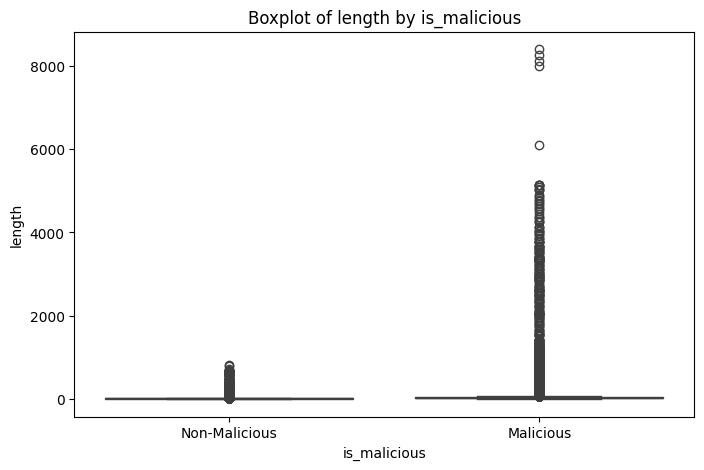

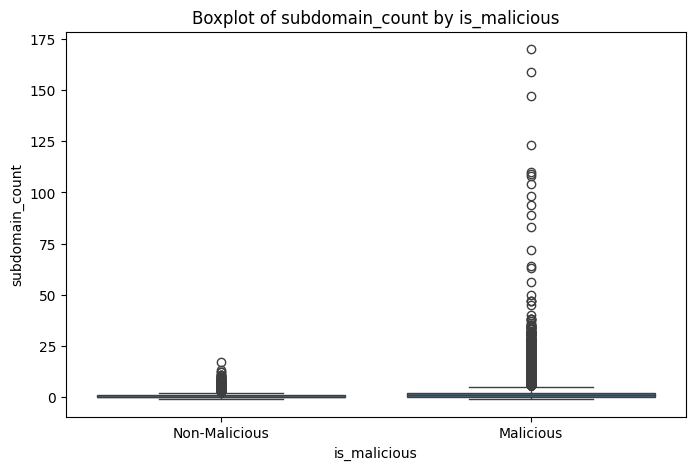

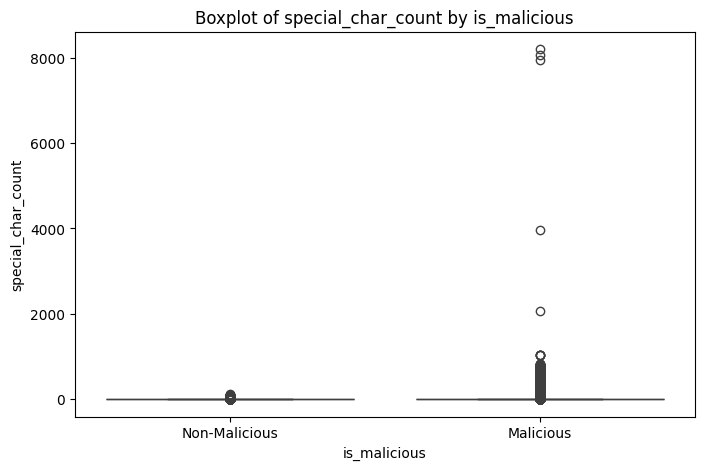

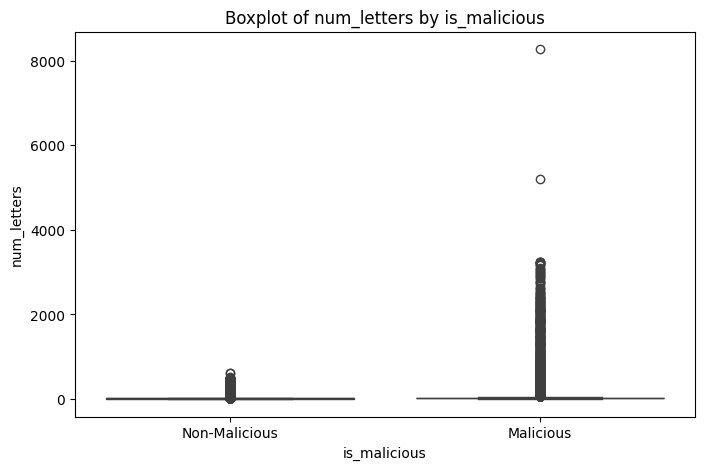

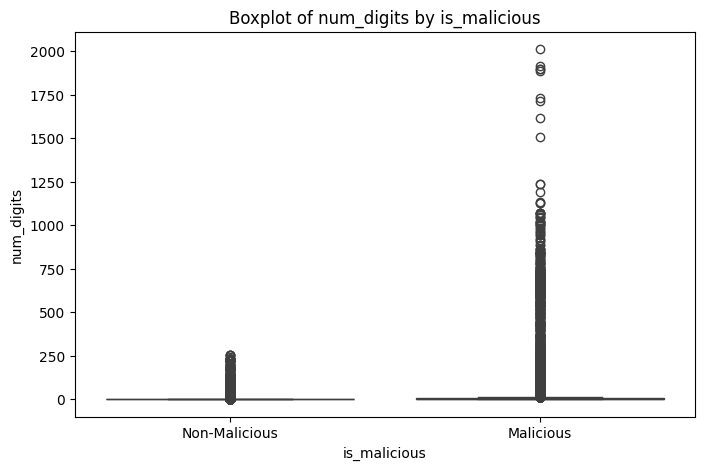

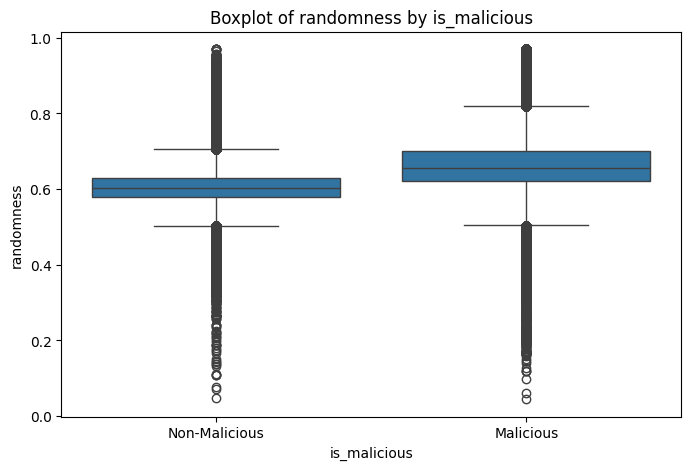

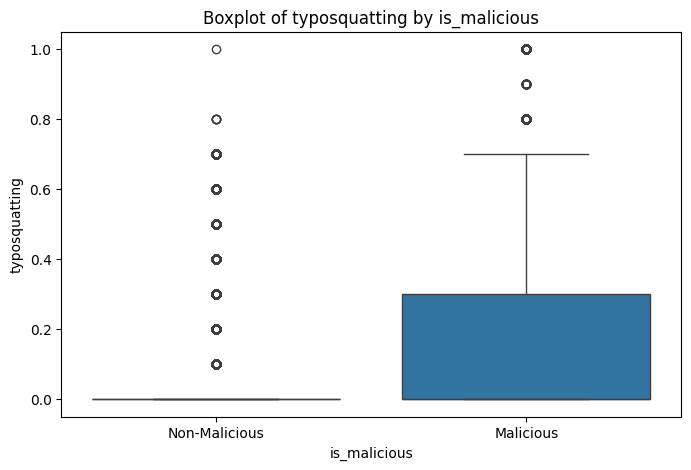

In [99]:
## 악성 여부에 따른 분포 확인
# 변수 목록
variables = ['length', 'subdomain_count', 'special_char_count', 'num_letters', 'num_digits', 'randomness', 'typosquatting']

# 박스플롯
for var in variables:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=train_df, x='label', y=var)
    plt.title(f"Boxplot of {var} by is_malicious")
    plt.xlabel("is_malicious")
    plt.ylabel(var)
    plt.xticks([0, 1], ['Non-Malicious', 'Malicious'])
    plt.show()

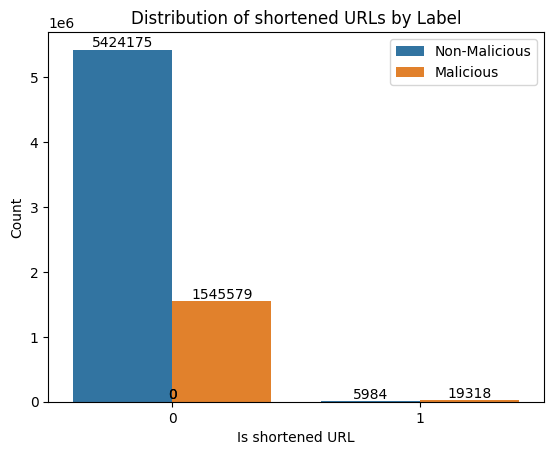

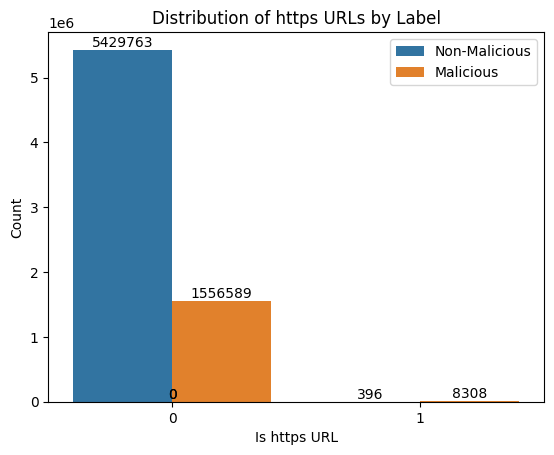

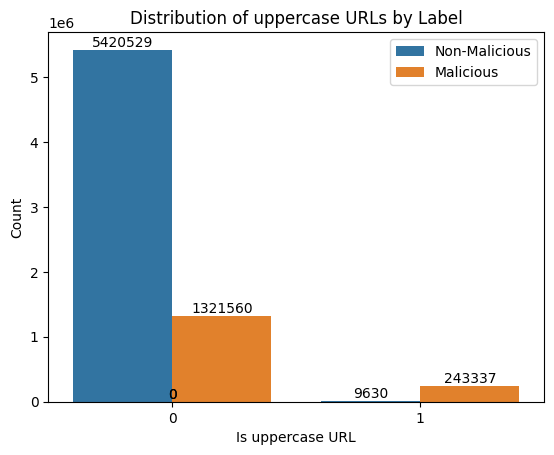

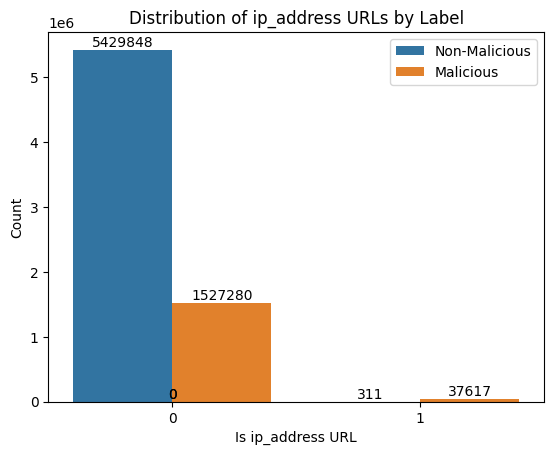

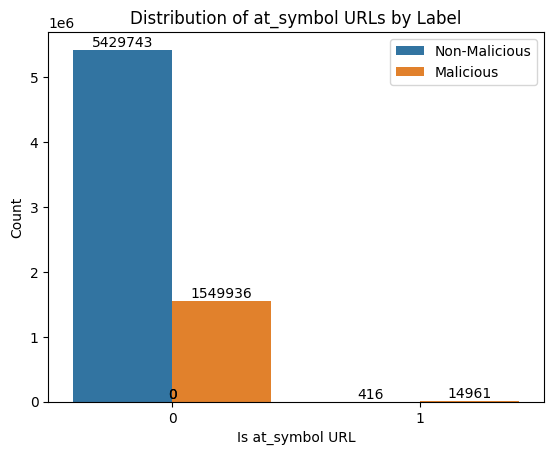

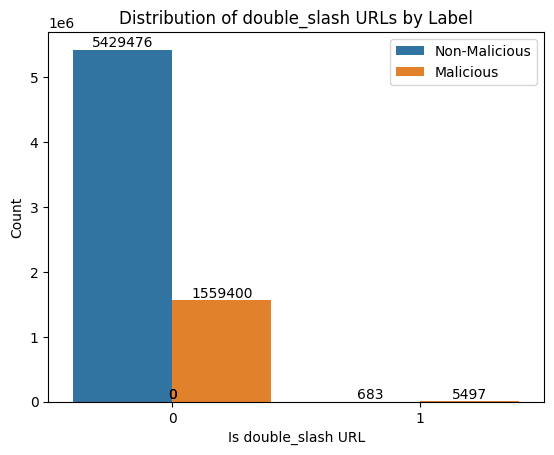

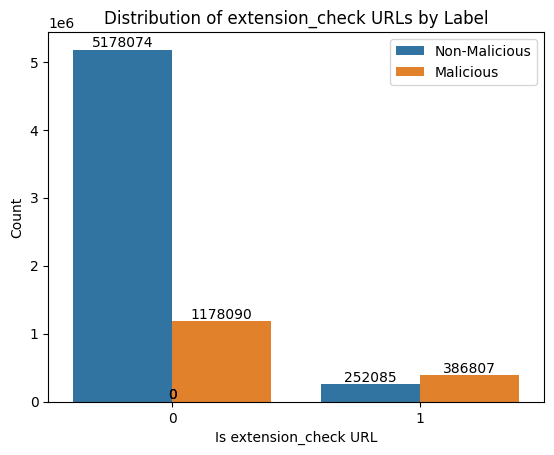

In [100]:
variables = ['shortened', 'https', 'uppercase', 'ip_address', 'at_symbol', 'double_slash', 'extension_check']

for var in variables:
    plt.figure(figsize=(6.4, 4.8))
    ax = sns.countplot(data=train_df, x=var, hue='label')

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom')

    plt.title(f'Distribution of {var} URLs by Label')
    plt.xlabel(f'Is {var} URL')
    plt.ylabel('Count')
    plt.legend(labels=['Non-Malicious', 'Malicious'])
    plt.show()

- URL 길이 길수록 악성 URL 가능성 높음
- 서브도메인 수 많을수록 악성 URL 가능성 높음
- 특수문자 많이 포함할수록 악성 URL 가능성 높음
- 숫자 많이 포함할수록 악성 URL 가능성 높음(문자도 동일)
- 짧은 링크일 경우 악성 URL 가능성 높음
- https가 프로토콜로서 사용되지 않는 경우 악성 URL 가능성 높음
- 대문자 포함 시 악성 URL 가능성 높음

### 상관 관계 분석

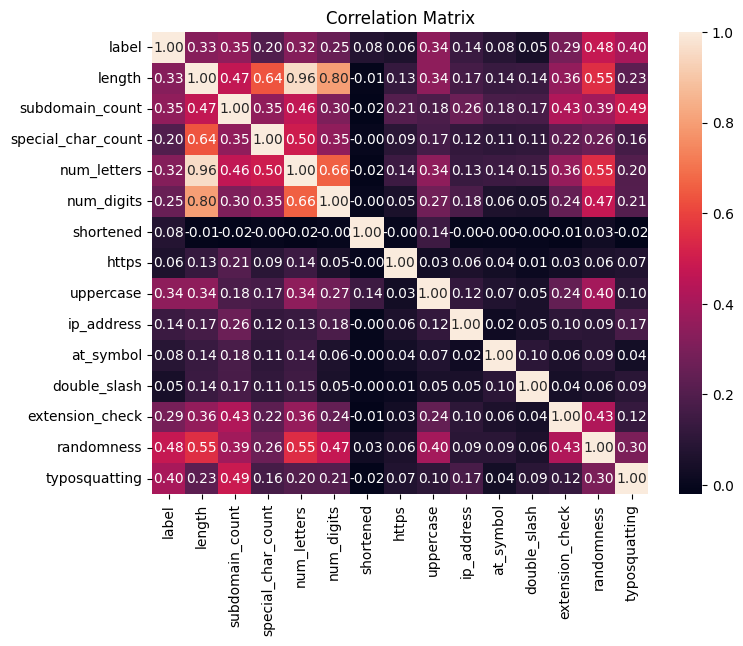

In [101]:
# 상관계수 계산
correlation_matrix = train_df.iloc[:, 2:].corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

-  EDA 결과에 따른 가설 설정 

    1. URL의 길이가 길수록 악성 URL일 확률이 높을 것이다. -> 악성 URL은 난독화와 탐지 회피를 위해 길이가 긴 경우가 많다.
    2. 서브도메인이 많을수록 악성 URL일 확률이 높을 것이다. -> 서브도메인은 피싱과 사용자 혼란을 유발하는 데 자주 활용된다.
    3. 특수문자가 많을수록 악성 URL일 확률이 높을 것이다. -> 특수문자는 난독화와 위장 목적으로 사용된다.


## 4. Pre-processing (전처리)

In [102]:
# 학습을 위한 학습 데이터의 피처와 라벨 준비
X = train_df.drop(columns=['ID', 'URL', 'label'])
y = train_df['label']

# 추론을 위한 평가 데이터의 피처 준비
X_test = test_df.drop(columns=['ID', 'URL'])

In [103]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

## 5. K-Fold Model Training (모델 학습)

In [104]:
# XGBoost 학습 및 모델 저장 (K-Fold)
kf = KFold(n_splits=4, shuffle=True, random_state=42)
models = []  # 모델을 저장할 리스트
auc_scores = []

for idx, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    print('-'*40)
    print(f'Fold {idx + 1} 번째 XGBoost 모델을 학습합니다.')
    
    # XGBoost 모델 학습
    model = XGBClassifier(
        eval_metric="auc",
        class_weight="balanced",
    )
    
    # 학습 및 Validation 성능 모니터링
    eval_set = [(X_train, y_train), (X_val, y_val)]
    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        verbose=True,
        # early_stopping_rounds=5
    )
    
    models.append(model)  # 모델 저장
    
    # 검증 데이터 예측 및 ROC-AUC 계산
    y_val_pred_prob = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred_prob)
    print(f"Fold {idx + 1} CV ROC-AUC: {auc:.4f}")
    print('-'*40)
    auc_scores.append(auc)

print(f"K-Fold 평균 ROC-AUC: {np.mean(auc_scores):.4f}")

----------------------------------------
Fold 1 번째 XGBoost 모델을 학습합니다.
[0]	validation_0-auc:0.87448	validation_1-auc:0.87404
[1]	validation_0-auc:0.88647	validation_1-auc:0.88592
[2]	validation_0-auc:0.88805	validation_1-auc:0.88752
[3]	validation_0-auc:0.88911	validation_1-auc:0.88852
[4]	validation_0-auc:0.89056	validation_1-auc:0.88998
[5]	validation_0-auc:0.89160	validation_1-auc:0.89101
[6]	validation_0-auc:0.89232	validation_1-auc:0.89178
[7]	validation_0-auc:0.89467	validation_1-auc:0.89411
[8]	validation_0-auc:0.89601	validation_1-auc:0.89541
[9]	validation_0-auc:0.89621	validation_1-auc:0.89563
[10]	validation_0-auc:0.89669	validation_1-auc:0.89612
[11]	validation_0-auc:0.89706	validation_1-auc:0.89647
[12]	validation_0-auc:0.89824	validation_1-auc:0.89767
[13]	validation_0-auc:0.89863	validation_1-auc:0.89806
[14]	validation_0-auc:0.89888	validation_1-auc:0.89831
[15]	validation_0-auc:0.89915	validation_1-auc:0.89858
[16]	validation_0-auc:0.89921	validation_1-auc:0.89863
[17]	

## 6. K-Fold Ensemble Inference (K-Fold 앙상블 추론)

In [105]:
# 평가 데이터 추론
# 각 Fold 별 모델의 예측 확률 계산
test_probabilities = np.zeros(len(X_test))

for model in models:
    test_probabilities += model.predict_proba(X_test)[:, 1]  # 악성 URL(1)일 확률 합산

# Soft-Voting 앙상블 (Fold 별 모델들의 예측 확률 평균)
test_probabilities /= len(models)
print('Inference Done.')

Inference Done.


## 7. Submission (제출 파일 생성)

In [106]:
# 결과 저장
test_df['probability'] = test_probabilities
test_df[['ID', 'probability']].to_csv('./submission.csv', index=False)
print('Done.')

Done.
